<a href="https://colab.research.google.com/github/mehmetkesik/tensorflow-basics/blob/main/04_transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leverage a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture while has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [20]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import sklearn

In [21]:
# Are we using a GPU?
!nvidia-smi

Sat Nov 26 19:12:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    35W /  70W |   9024MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [22]:
# Get data (10% oof 10 food classes from Food101)
import zipfile
from pathlib import Path

# Download the data
if not Path("10_food_classes_10_percent").is_dir():
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

  # Unzip the downloaded file
  zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
  zip_ref.extractall()
  zip_ref.close()

In [23]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

## Creating data loaders (preparing the data)

We'll use the `image_dataset_from_folder` function to load in our images in batches.

In [24]:
# Setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

rescaling = layers.Rescaling(1./255)

print("Training images:")
train_data = image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)#.map(lambda x, y: (rescaling(x), y))
class_names = train_data.class_names
num_classes = len(class_names)
train_data = train_data.map(lambda x, y: (rescaling(x), y))

print("Test images:")
test_data = image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
).map(lambda x, y: (rescaling(x), y))

Training images:
Found 750 files belonging to 10 classes.
Test images:
Found 2500 files belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callback are extra functionality you can add to your models to be performed during or after training. Some of the popular callbacks:

* Traking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback


In [25]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to: {log_dir}")
  return tensorboard_callback

🔑 **Note:** You can customize the directory where you TensorBoard logs(model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from stratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev

https://paperswithcode.com/sota

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [26]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [27]:
# Let's make a create_model() function to create a model frol a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                      trainable=False,
                                      name="feature_extractor_layer",
                                      input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  
  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [28]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=num_classes)

In [29]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [30]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [31]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log file to: tensorflow_hub/resnet50v2/20221126-191208
Epoch 1/5
24/24 [==============================] - 14s 430ms/step - loss: 1.9627 - accuracy: 0.3493 - val_loss: 1.2415 - val_accuracy: 0.5820
Epoch 2/5
24/24 [==============================] - 10s 411ms/step - loss: 0.9207 - accuracy: 0.7200 - val_loss: 0.8801 - val_accuracy: 0.7180
Epoch 3/5
24/24 [==============================] - 13s 535ms/step - loss: 0.6328 - accuracy: 0.8253 - val_loss: 0.7570 - val_accuracy: 0.7556
Epoch 4/5
24/24 [==============================] - 10s 425ms/step - loss: 0.4856 - accuracy: 0.8680 - val_loss: 0.7044 - val_accuracy: 0.7740
Epoch 5/5
24/24 [==============================] - 13s 533ms/step - loss: 0.3883 - accuracy: 0.9120 - val_loss: 0.6728 - val_accuracy: 0.7784


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the training examples.

In [32]:
# Download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Import helper functions
from helper_functions import *

helper_functions.py already exist, skipping download...


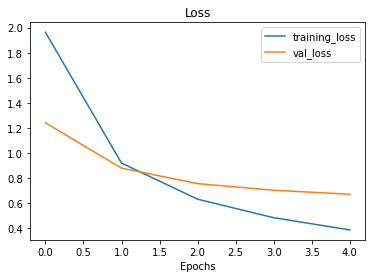

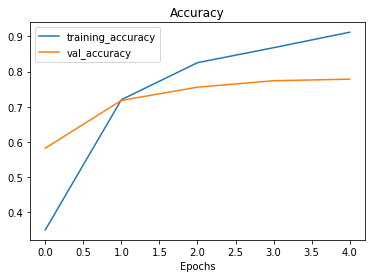

In [33]:
# Plot the validation and training curves
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [34]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=Adam(),
                           metrics=["accuracy"])

In [35]:
# Fit EfficientNet model 10% of training data
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221126-191325
Epoch 1/5
24/24 [==============================] - 18s 365ms/step - loss: 1.8649 - accuracy: 0.4347 - val_loss: 1.3060 - val_accuracy: 0.7196
Epoch 2/5
24/24 [==============================] - 8s 327ms/step - loss: 1.0724 - accuracy: 0.7840 - val_loss: 0.8732 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 8s 330ms/step - loss: 0.7644 - accuracy: 0.8320 - val_loss: 0.7050 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 8s 328ms/step - loss: 0.6144 - accuracy: 0.8640 - val_loss: 0.6167 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 8s 323ms/step - loss: 0.5184 - accuracy: 0.8920 - val_loss: 0.5617 - val_accuracy: 0.8616


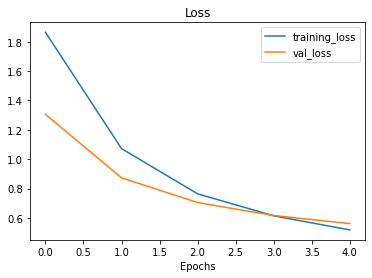

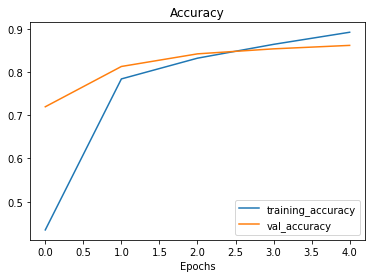

In [36]:
plot_loss_curves(efficientnet_history)

In [37]:
effnetb7_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"

effnetb7_model = create_model(effnetb7_url,
                              num_classes=num_classes)

effnetb7_model.compile(loss="categorical_crossentropy",
                       optimizer=Adam(),
                       metrics=["accuracy"])

effnetb7_history = effnetb7_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="effnetb7")])

Saving TensorBoard log files to: tensorflow_hub/effnetb7/20221126-192245
Epoch 1/5
24/24 [==============================] - 85s 2s/step - loss: 1.6115 - accuracy: 0.5440 - val_loss: 0.9762 - val_accuracy: 0.7904
Epoch 2/5
24/24 [==============================] - 50s 2s/step - loss: 0.7977 - accuracy: 0.8427 - val_loss: 0.6724 - val_accuracy: 0.8340
Epoch 3/5
24/24 [==============================] - 50s 2s/step - loss: 0.5834 - accuracy: 0.8627 - val_loss: 0.5714 - val_accuracy: 0.8516
Epoch 4/5
24/24 [==============================] - 50s 2s/step - loss: 0.4831 - accuracy: 0.8920 - val_loss: 0.5251 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 37s 2s/step - loss: 0.4126 - accuracy: 0.9040 - val_loss: 0.4957 - val_accuracy: 0.8604


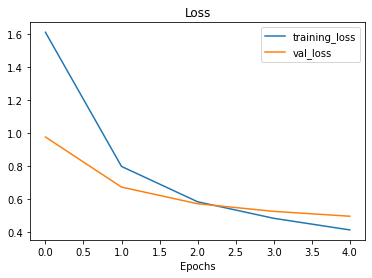

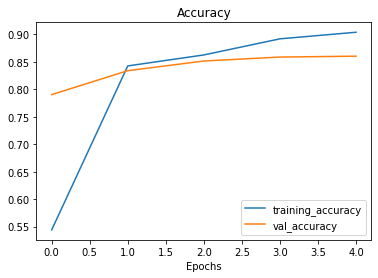

In [38]:
plot_loss_curves(effnetb7_history)